**Install Packages**

In [61]:
#!pip install pyLDAvis
#!pip install langdetect
#!pip install WordCloud
#!pip install gensim
#!pip install translate
#!pip install googletrans==4.0.0-rc1
#!pip install ekphrasis
#!pip install tweet-preprocessor

In [189]:
# Import libraries
from flask import Flask,render_template,url_for,request
import pickle
import joblib


import pandas as pd
import numpy as np
import re
from ekphrasis.classes.segmenter import Segmenter
import preprocessor as p
from time import time

import json
from collections import Counter
from wordcloud import WordCloud

# Laguage Translation
import googletrans
from googletrans import Translator
from langdetect import detect, detect_langs, DetectorFactory
DetectorFactory.seed = 0

# text processing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint

#Clustering
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
from pyLDAvis import gensim_models as gensimvis
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\togholaja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\togholaja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\togholaja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [73]:
# Load data
# Only a thousand samples will be used due to processing limitations
tweet_df = pd.read_csv('twitter_dataset.csv')#.sample(200)
print('Dataset size:',tweet_df.shape)
tweet_df.head(1)

Dataset size: (200, 29)


,TweetPostedTime,TweetID,TweetBody,TweetRetweetFlag,TweetSource,TweetInReplyToStatusID,TweetInReplyToUserID,TweetInReplyToScreenName,TweetRetweetCount,TweetFavoritesCount,TweetHashtags,TweetPlaceID,TweetPlaceName,TweetPlaceFullName,TweetCountry,TweetPlaceBoundingBox,TweetPlaceAttributes,TweetPlaceContainedWithin,UserID,UserLocation,UserDescription,UserLink,UserExpandedLink,UserFollowersCount,UserFriendsCount,UserListedCount,UserSignupDate,UserTweetCount,tweet.place
34875,Tue Dec 20 02:00:56 +0000 2016,811028581140860928,Get to #Magnetic #Island before the crowds discover this #Tropical #Paradise #ttot #travel #australia #queensland https://t.co/aPLP3c2a1I,False,"<a href=""http://www.hootsuite.com"" rel=""nofollow"">Hootsuite</a>",NaN,NaN,NaN,0,0,"Magnetic, Island, Tropical, Paradise, ttot, travel, australia, queensland",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1424358728,Adelaide,#lifestyle #fashion #travel #fitness blog https://t.co/X1elT1CTwm,https://t.co/gb0ToCOgTQ,http://www.travellingking.com,10334,11128,715,Mon May 13 01:10:16 +0000 2013,27957,NaN


In [74]:
print('shape before: ', tweet_df.shape)
tweet_df.drop_duplicates(subset='TweetBody',ignore_index=True,inplace=True)
print('\nshape now: ', tweet_df.shape)

shape before:  (200, 29)

shape now:  (118, 29)


# **Question 1**

**1a: Detect Languages in Twitter Dataset**

In [75]:
# Function for language detection
def detect_languages(tweets):
    language = detect(tweets)
    return language

# Function to check prediction % correctness
def language_purity(tweets):
    language_score = detect_langs(tweets)
    return language_score

def translate_words(data):
    translator = Translator()
    translator.raise_Exception = True
    data = data.apply(translator.translate, dest='en') \
                    .apply(getattr, args=('text',))
    return data

In [76]:
start_time = time()
tweet_df['languages'] = tweet_df['TweetBody'].apply(detect_languages)

tweet_df['language_score'] = tweet_df['TweetBody'].apply(language_purity)

print('Languages present in the tweets: {}. \n{} in total'.format(tweet_df['languages'].unique(), len(tweet_df['languages'].unique())))

end_time = time()
print('\nTotal time taken to run: {} minutes'.format(round((end_time - start_time)/60, 1)))

Languages present in the tweets: ['en' 'ja' 'id' 'no' 'ru' 'es' 'sl' 'et' 'bg' 'ca']. 
10 in total

Total time taken to run: 0.0 minutes


**1b: Finding NGrams in Tweet Dataset**

First we clean data

In [77]:
start_time = time()

TweetBody_df  = pd.DataFrame(tweet_df['TweetBody'])
translator = Translator()

#google translate API allows 5 calls/second, caps it at 200k a day so impossible to run for all tweets
TweetBody_df['TweetBody'] = translate_words(TweetBody_df['TweetBody'])

TweetBody_df['hashtag'] = TweetBody_df['TweetBody'].apply(lambda x: re.findall(r"#(\w+)", x)) # Extract hashtags from TweetBody column

additional  = ['RT','rt','rts','retweet', 'to','of']
swords = set().union(stopwords.words('english'),additional)


TweetBody_df['TweetBody_clean'] = TweetBody_df['TweetBody'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
          .str.replace(' +',' ')\
          .str.replace('\d+', ' ')\
          .apply(lambda x: [i for i in x.split() if not i in swords])

ps = PorterStemmer()
TweetBody_df['TweetBody_stemmed'] = TweetBody_df['TweetBody_clean'].apply(lambda x: [ps.stem(i) for i in x if i != ''])

lm = WordNetLemmatizer()
TweetBody_df['TweetBody_lm'] = TweetBody_df['TweetBody_clean'].apply(lambda x: [lm.lemmatize(i) for i in x if i != ''])

# segmenter using the word statistics from Twitter
seg_tw = Segmenter(corpus="twitter")
a = []

for i in range(len(TweetBody_df)):
    if TweetBody_df['TweetBody_lm'][i] != a:
        listToStr1 = ' '.join([str(elem) for elem in \
                               TweetBody_df['TweetBody_lm'][i]])
        TweetBody_df.loc[i,'TweetBody_Seg'] = seg_tw.segment(listToStr1)

TweetBody_df.head()

end_time = time()
print('\nTotal time taken to run: {} minutes'.format(round((end_time - start_time)/60, 1)))

<ipython-input-77-69e290071500>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  TweetBody_df['TweetBody_clean'] = TweetBody_df['TweetBody'].str.lower()\


Reading twitter - 1grams ...
Reading twitter - 2grams ...

Total time taken to run: 0.7 minutes


In [78]:
TweetBody_df.head()

,TweetBody,hashtag,TweetBody_clean,TweetBody_stemmed,TweetBody_lm,TweetBody_Seg
0,Get to #Magnetic #Island before the crowds discover this #Tropical #Paradise #ttot #travel #australia #queensland https://t.co/aPLP3c2a1I,"[Magnetic, Island, Tropical, Paradise, ttot, travel, australia, queensland]","[get, magnetic, island, crowds, discover, tropical, paradise, ttot, travel, australia, queensland]","[get, magnet, island, crowd, discov, tropic, paradis, ttot, travel, australia, queensland]","[get, magnetic, island, crowd, discover, tropical, paradise, ttot, travel, australia, queensland]",get magnetic island crowd discover tropical paradise ttot travel australia queensland
1,RT @lajewcom: Beautiful #Israel #Jerusalem 🇮🇱Travel photography by: Helena-Reet Ennet @Ohmygossip #travel #travelpics #travelblogger #touri…,"[Israel, Jerusalem, travel, travelpics, travelblogger, touri]","[beautiful, israel, jerusalem, travel, photography, helena, reet, ennet, travel, travelpics, travelblogger, touri]","[beauti, israel, jerusalem, travel, photographi, helena, reet, ennet, travel, travelp, travelblogg, touri]","[beautiful, israel, jerusalem, travel, photography, helena, reet, ennet, travel, travelpics, travelblogger, touri]",beautiful israel jerusalem travel photography helena reet ennet travel travelpics travel blogger touri
2,"HCM City, Quang Ninh tourism up https://t.co/6VAW2VzYSh #travel",[travel],"[hcm, city, quang, ninh, tourism, travel]","[hcm, citi, quang, ninh, tourism, travel]","[hcm, city, quang, ninh, tourism, travel]",hcm city quang ninh tourism travel
3,#Japan #Japantravel #travel Japan News This Week 24 July 2016 https://t.co/QuEiWtevM9 https://t.co/ekttpCiNSl,"[Japan, Japantravel, travel]","[japan, japantravel, travel, japan, news, week, july]","[japan, japantravel, travel, japan, news, week, juli]","[japan, japantravel, travel, japan, news, week, july]",japan japantravel travel japan news week july
4,"RT @StylishRentals: Nice vacation rental Condo I found in Mission Beach, San Diego CA, USA! https://t.co/QUj0185ecQ #travel via @vrbo https…",[travel],"[nice, vacation, rental, condo, found, mission, beach, san, diego, ca, usa, travel, via]","[nice, vacat, rental, condo, found, mission, beach, san, diego, ca, usa, travel, via]","[nice, vacation, rental, condo, found, mission, beach, san, diego, ca, usa, travel, via]",nice vacation rental condo found mission beach san diego ca usa travel via


In [79]:
#Find N-grams and print the most common 
word_list = TweetBody_df['TweetBody_Seg']
word_list = re.sub(r'\d+', ' ', str(word_list))
word_list= nltk.word_tokenize(str(word_list))

ngrams_df = pd.DataFrame()
for i in range(2,10):
    ngrams_count = ngrams(word_list,i)
    countng = pd.DataFrame({'n-grams':i, 'popular_ngrams':Counter(ngrams_count).most_common(1)})
    ngrams_df = ngrams_df.append(countng)
    ngrams_df
ngrams_df.set_index('n-grams',drop=True, inplace=True)
ngrams_df

,popular_ngrams
n-grams,
2,"((please, travel), 9)"
3,"((please, travel, traveller), 6)"
4,"((israel, jerusalem, travel, photography), 3)"
5,"((israel, jerusalem, travel, photography, helena), 3)"
6,"((israel, jerusalem, travel, photography, helena, reet), 3)"
7,"((israel, jerusalem, travel, photography, helena, reet, ennet), 3)"
8,"((israel, jerusalem, travel, photography, helena, reet, ennet, travel), 3)"
9,"((israel, jerusalem, travel, photography, helena, reet, ennet, travel, travelpics), 3)"


# **Question 2**

#### 2a: Finding the popular clusters of tweets

In [80]:
stop_words = stopwords.words('english')
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

#Create corpus
data = TweetBody_df["TweetBody_lm"].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = (data_words)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View corpus
#print(corpus)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('australia', 1),
  ('crowd', 1),
  ('discover', 1),
  ('get', 1),
  ('island', 1),
  ('magnetic', 1),
  ('paradise', 1),
  ('queensland', 1),
  ('travel', 1),
  ('tropical', 1),
  ('ttot', 1)]]

In [85]:
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 10 topics

print('Most popular clusters of tweets and their weightings : \n ')
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

#Saved Model
joblib.dump(lda_model, 'lda_model.pkl')

Most popular clusters of tweets and their weightings : 
 
[(0,
  '0.067*"travel" + 0.015*"ttot" + 0.014*"wanderlust" + 0.014*"familytravel" + '
  '0.013*"jumping" + 0.013*"germany" + 0.013*"epic" + 0.013*"alp" + '
  '0.013*"jason" + 0.013*"rtw"'),
 (1,
  '0.069*"travel" + 0.030*"cruise" + 0.020*"holiday" + 0.018*"shop" + '
  '0.018*"tag" + 0.018*"luggage" + 0.018*"waterfall" + 0.012*"hiking" + '
  '0.010*"top" + 0.010*"last"'),
 (2,
  '0.041*"travel" + 0.031*"holiday" + 0.029*"life" + 0.014*"love" + '
  '0.011*"museum" + 0.010*"season" + 0.010*"reading" + 0.010*"morning" + '
  '0.010*"history" + 0.010*"good"'),
 (3,
  '0.081*"travel" + 0.036*"please" + 0.031*"traveller" + 0.016*"holiday" + '
  '0.012*"loyalty" + 0.012*"blog" + 0.011*"hotel" + 0.011*"join" + '
  '0.010*"dinner" + 0.010*"romantic"')]


['lda_model.pkl']

In [86]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.812026308606192

Coherence Score:  0.40196690019405246


In [87]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.027089 -0.119318       1        1  30.750014
2     -0.102319  0.100742       2        1  25.606683
0     -0.011861 -0.029069       3        1  24.051875
1      0.141270  0.047645       4        1  19.591428, topic_info=              Term       Freq      Total Category  logprob  loglift
179         please  12.000000  12.000000  Default  30.0000  30.0000
213      traveller  10.000000  10.000000  Default  29.0000  29.0000
135         cruise   6.000000   6.000000  Default  28.0000  28.0000
327           life   8.000000   8.000000  Default  27.0000  27.0000
76         holiday  17.000000  17.000000  Default  26.0000  26.0000
590            tag   4.000000   4.000000  Default  25.0000  25.0000
587        luggage   4.000000   4.000000  Default  24.0000  24.0000
589           shop   4.000000   4.000000  Default  23.0000  23.0000
645      waterfall   4.000000   4.000000  Default  22.0000  22.0000
10            ttot   4.000000   4.000000  Default  21.0000  21.0000
260     wanderlust   3.000000   3.000000  Default  20.0000  20.0000
59    familytravel   3.000000   3.000000  Default  19.0000  19.0000
617        jumping   5.000000   5.000000  Default  18.0000  18.0000
614           epic   3.000000   3.000000  Default  17.0000  17.0000
615        germany   3.000000   3.000000  Default  16.0000  16.0000
616          jason   3.000000   3.000000  Default  15.0000  15.0000
618            rtw   3.000000   3.000000  Default  14.0000  14.0000
613            alp   3.000000   3.000000  Default  13.0000  13.0000
639      insurance   3.000000   3.000000  Default  12.0000  12.0000
640           need   3.000000   3.000000  Default  11.0000  11.0000
237         hiking   2.000000   2.000000  Default  10.0000  10.0000
382         really   3.000000   3.000000  Default   9.0000   9.0000
387        loyalty   4.000000   4.000000  Default   8.0000   8.0000
221           blog   4.000000   4.000000  Default   7.0000   7.0000
371         museum   3.000000   3.000000  Default   6.0000   6.0000
547            top   2.000000   2.000000  Default   5.0000   5.0000
436           last   2.000000   2.000000  Default   4.0000   4.0000
195    destination   2.000000   2.000000  Default   3.0000   3.0000
583            way   4.000000   4.000000  Default   2.0000   2.0000
446          hotel   3.000000   3.000000  Default   1.0000   1.0000
179         please  11.572446  12.029908   Topic1  -3.3277   1.1405
213      traveller  10.118765  10.575280   Topic1  -3.4619   1.1352
387        loyalty   3.862804   4.319317   Topic1  -4.4249   1.0676
221           blog   3.862591   4.319278   Topic1  -4.4250   1.0675
446          hotel   3.499150   3.955663   Topic1  -4.5238   1.0567
591      amsterdam   3.135481   3.591995   Topic1  -4.6335   1.0434
592         dinner   3.135481   3.591995   Topic1  -4.6335   1.0434
593     restaurant   3.135481   3.591995   Topic1  -4.6335   1.0434
594       romantic   3.135481   3.591995   Topic1  -4.6335   1.0434
595      valentine   3.135481   3.591995   Topic1  -4.6335   1.0434
599            ski   3.135481   3.591994   Topic1  -4.6335   1.0434
596        feature   3.135481   3.591994   Topic1  -4.6335   1.0434
597        project   3.135481   3.591994   Topic1  -4.6335   1.0434
598        related   3.135481   3.591994   Topic1  -4.6335   1.0434
600          climb   3.135292   3.591996   Topic1  -4.6336   1.0433
601    kilimanjaro   3.135292   3.591996   Topic1  -4.6336   1.0433
602         summit   3.135292   3.591996   Topic1  -4.6336   1.0433
603          trail   3.135292   3.591996   Topic1  -4.6336   1.0433
604         tusker   3.135292   3.591996   Topic1  -4.6336   1.0433
605          valor   3.135292   3.591996   Topic1  -4.6336   1.0433
245           join   3.499136   4.241785   Topic1  -4.5238   0.9868
34           diego   1.643985   2.100498   Topic1  -5.2792   0.9342
39             san   1.643985

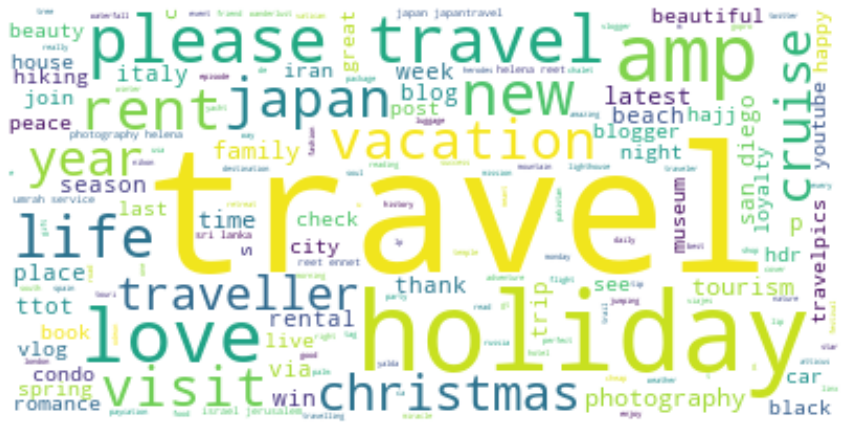

In [88]:
# Create and generate a word cloud image:
text = str(TweetBody_df['TweetBody_Seg'])

# Set figure size
plt.figure(figsize=(15, 15))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2b: Assumptions made

- Hashtags used in tweets are assumed relevant to tweet so included in solution
- Retweets are considered as duplicates to avoid noise due to too many replications

# **Question 3**

**Positives**
- By including the TweetPostedTime, We can can better understand seasonalities, in terms of what and why users are tweeting on a given topic.
- The TweetRetweetFlag feature should help us count how often a tweet is retweeted. This way, we understand the significance of a given tweet.
- Some countries are more of interest than others. So including the TweetCountry feature could improve the model.
- Some of the user specific features can also be useful in understanding the significance of the tweet.

**Negetives**
- Some user location related features can create GDPR issues which could harm the business reputation if used.
- Generally difficult to get full dataset on user related fetaures i.e. tweet.place, as people usually turn these off for privacy. This adds nulls in the dataset and therefore may not be too useful as a predictor.

# **Question 4**

<span style="color:blue">*- Run "Python app.py" in command line to activate model. Click on link to add message.* text</span>.

- **Screenshot of result:**


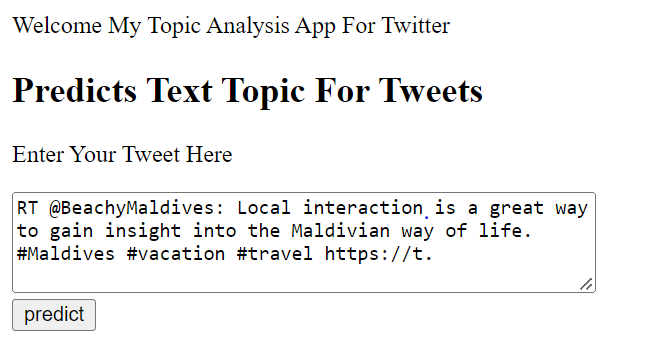

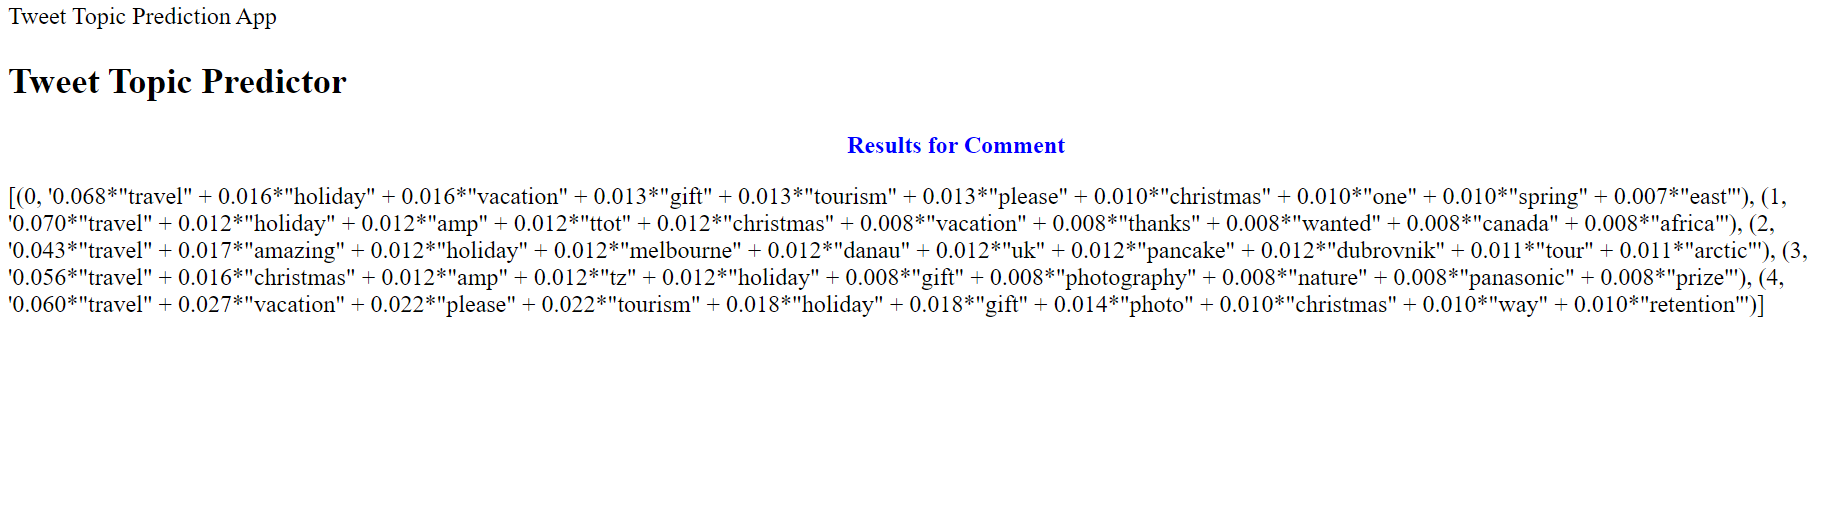

# **Question 5**
- As a business, uderstanding what topic is trending can provide insights on likely destinations for customers. For instance, travel and holiday seems to be dominant for these set of users. With this understanding, it becomes easier to scale operations, be more aggressive in advertising and reaching out to potential travellers. Likewise, we scale down in seasons where travel is out of mind for customers. Overall, should improve target spending and optimize efficiency.

# **Question 6**

In [201]:
data = pd.read_csv('twitter_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42368 entries, 0 to 42367
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TweetPostedTime            42368 non-null  object 
 1   TweetID                    42368 non-null  int64  
 2   TweetBody                  42368 non-null  object 
 3   TweetRetweetFlag           42368 non-null  bool   
 4   TweetSource                42368 non-null  object 
 5   TweetInReplyToStatusID     101 non-null    float64
 6   TweetInReplyToUserID       189 non-null    float64
 7   TweetInReplyToScreenName   189 non-null    object 
 8   TweetRetweetCount          42368 non-null  int64  
 9   TweetFavoritesCount        42368 non-null  int64  
 10  TweetHashtags              42268 non-null  object 
 11  TweetPlaceID               1000 non-null   object 
 12  TweetPlaceName             1000 non-null   object 
 13  TweetPlaceFullName         1000 non-null   obj

In [202]:
#Drop columns with null values
data = data.dropna(axis=1)

#Drop useless columns
cols = ['TweetPostedTime','TweetID','TweetBody','TweetSource','UserID','UserSignupDate']
data.drop(cols, axis = 1, inplace=True)
data.head(2)

,TweetRetweetFlag,TweetRetweetCount,TweetFavoritesCount,UserFollowersCount,UserFriendsCount,UserListedCount,UserTweetCount
0,True,1,0,6334,6144,1917,33556
1,True,1,0,154,371,180,3201


In [203]:
#Make Retweet Flag binary
data.TweetRetweetFlag = np.where(data.TweetRetweetFlag=='True',1,0)

In [204]:
# Normalise features
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBModel
import xgboost

In [205]:
X = data.drop('TweetFavoritesCount', axis=1)
y = data['TweetFavoritesCount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [207]:
from xgboost import XGBRegressor
params = {'colsample_bytree': 1,'learning_rate': 0.1,
                'max_depth': 12, 'alpha': 0,'n_estimators':128, 'eval_metric':'logloss'}

# create an xgboost regression model
xgb = XGBRegressor(**params)


model = xgb.fit(X_train, y_train)

# make a prediction
y_pred = xgb.predict(X_test)

print('\nModel Score: ',round(xgb.score(X_test, y_test),3))



Model Score:  0.39


In [208]:
X_test['TweetFavoritesCount_pred'] = y_pred.astype('int')
X_test['TweetFavoritesCount'] = y_test
X_test.head()

<ipython-input-208-2052c6d23161>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['TweetFavoritesCount_pred'] = y_pred.astype('int')
<ipython-input-208-2052c6d23161>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['TweetFavoritesCount'] = y_test


,TweetRetweetFlag,TweetRetweetCount,UserFollowersCount,UserFriendsCount,UserListedCount,UserTweetCount,TweetFavoritesCount_pred,TweetFavoritesCount
27911,0,1,2971,2053,118,199438,0,0
30349,0,3228,42,46,36,24488,0,0
12528,0,3069,37,27,25,38437,0,0
40906,0,0,23415,16267,3140,110379,1,3
14773,0,3241,92,30,108,29123,0,0


In [268]:
X_test[['TweetFavoritesCount', 'TweetFavoritesCount_pred']].sample(10)

,TweetFavoritesCount,TweetFavoritesCount_pred
19882,0,0
14165,0,0
2259,0,0
12009,0,0
19973,0,0
16278,0,0
12724,0,0
24372,0,0
37541,0,0
217,0,0
